In [3]:
import torch
import numpy as np
from spherical_inr.inr import INR, HerglotzNet
import spherical_inr.differentiation as D
import matplotlib.pyplot as plt

In [4]:
inr = INR(
    num_atoms=50,
    mlp_sizes=2*[50],
    output_dim=1,
    input_dim =2, 
    pe = "herglotz",
    activation="sin",
)

In [5]:
def f_harmonic(x):
    return torch.sin(x[..., 0]) * torch.cosh(x[..., 1])

In [6]:
grid_points = 100
x1 = np.linspace(-np.pi, np.pi, grid_points)
x2 = np.linspace(-np.pi, np.pi, grid_points)
X1, X2 = np.meshgrid(x1, x2)

grid = np.stack([X1, X2], axis=-1).reshape(-1, 2)
grid_tensor = torch.tensor(grid, dtype=torch.float32)

In [7]:
boundary_mask = (np.abs(X1) == np.pi) | (np.abs(X2) == np.pi)

xtrain = grid_tensor[boundary_mask.reshape(-1)].requires_grad_(True)

with torch.no_grad():
    ytrain = f_harmonic(xtrain)

xtest = grid_tensor
ytest = f_harmonic(xtest)

xreg = xtest[::5].clone().requires_grad_(True)
yreg = ytest[::5].clone()

In [8]:
MSE = torch.nn.MSELoss()

In [11]:
def loss_fn(target, ypred, yreg, xreg):
    reg = D.cartesian_laplacian(yreg, xreg, track=True).pow(2).mean()
    mse = MSE(target, ypred)
    loss = reg + mse
    return loss
   

In [12]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-3)
epochs = 5000

for ep in range(epochs):

    inr.train()
    optimizer.zero_grad()

    ypred = inr(xtrain).squeeze()
    yreg = inr(xreg).squeeze()

    loss = loss_fn(ytrain, ypred, yreg, xreg)
    loss.backward()
    optimizer.step()

    if ep % 500 == 0:
        print(f"Epoch {ep}: Loss {loss.item():.4f}")


Epoch 0: Loss 33.2523
Epoch 500: Loss 0.2837
Epoch 1000: Loss 0.0415
Epoch 1500: Loss 0.0204
Epoch 2000: Loss 0.0121
Epoch 2500: Loss 0.0084
Epoch 3000: Loss 0.0060
Epoch 3500: Loss 0.0044
Epoch 4000: Loss 0.0034
Epoch 4500: Loss 0.0026


In [13]:
xtest = xtest.requires_grad_(True)
ypred = inr(xtest).squeeze()

lap= D.cartesian_laplacian(ypred, xtest).pow(2).mean().detach_()
mse = MSE(ytest, ypred).detach_()
print(f"Lap Mean Square Value : {lap.item():.9f}")
print(f"MSE Value : {mse.item():.9f}")

Lap Mean Square Value : 0.009142663
MSE Value : 0.000022965


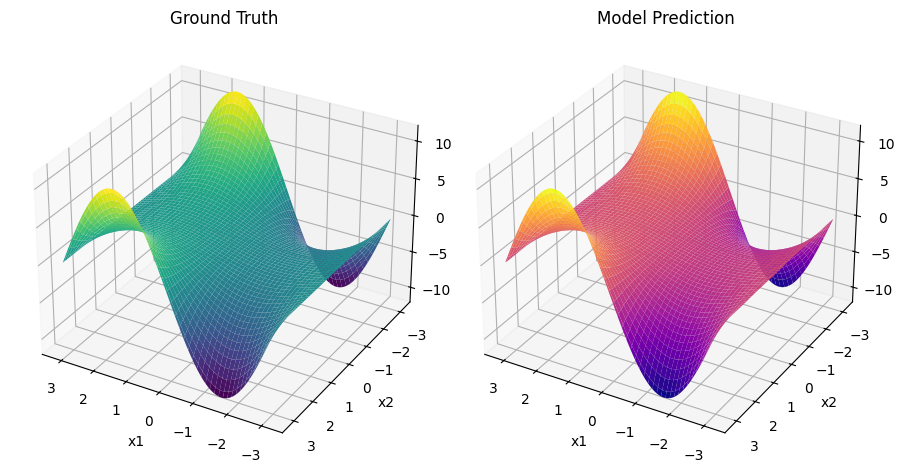

In [14]:
fig = plt.figure(figsize=(9, 9), dpi=100)


ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1, X2, ytest.view(grid_points, grid_points).detach().numpy(), cmap='viridis', alpha=1.0)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Ground Truth')
ax1.view_init(elev=30, azim=120)  


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1, X2, ypred.view(grid_points, grid_points).detach().numpy(), cmap='plasma', alpha=1.0)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Model Prediction')
ax2.view_init(elev=30, azim=120) 


plt.tight_layout()
plt.show()